In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import pkgutil
import importlib
import tqdm

In [4]:
from torchapprox.utils.evoapprox import search_space
search_space()

[ApproximateMultiplier(name='mul8s_1KV6', performance_metric=0.425, error_map=array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])),
 ApproximateMultiplier(name='mul8s_1KV8', performance_metric=0.422, error_map=array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0, -1, -2, ..., -1, -2, -3],
        [ 0, -2,  0, ..., -2,  0, -2],
        ...,
        [ 0, -1, -2, ..., -1, -2, -3],
        [ 0, -2,  0, ..., -2,  0, -2],
        [ 0, -3, -2, ..., -3, -2, -5]])),
 ApproximateMultiplier(name='mul8s_1KV9', performance_metric=0.41, error_map=array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,  -1,  -2, ...,  -5,  -6,  -7],
        [  0,  -2,  -4, ...,  -2,  -4,  -6],
        ...,
        [  0,  -5,  -2, ...,  -9,  -6, -11],
        [  0,  -6,  -4, ...,  -6,  -4, -10],
        [  0,  -7,  -6, ..., -11, -10, -17]])),
 ApproximateMultipli

In [41]:
import evoapproxlib as eal
multipliers = [m.name for m in pkgutil.iter_modules(eal.__path__) if 'mul8s_' in m.name]
attrs = ['MAE_PERCENT', 'MAE', 'WCE_PERCENT', 'WCE', 'WCRE_PERCENT', 'EP_PERCENT', 'MRE_PERCENT', 'MSE', 'PDK45_PWR', 'PDK45_AREA', 'PDK45_DELAY']
for m in multipliers:
    print(m)

mul8s_1KV6
mul8s_1KV8
mul8s_1KV9
mul8s_1KVA
mul8s_1KVM
mul8s_1KVP
mul8s_1KVQ
mul8s_1KX5
mul8s_1KXF
mul8s_1L12
mul8s_1L2J
mul8s_1L2L
mul8s_1L2N


In [42]:
def multiplier_output(multiplier, x, y, signed=True, bitwidth=8):
    axmul = np.vectorize(multiplier.calc)
    z = axmul(x, y)
    if signed:
        z[z >= 2**(2*bitwidth-1)] -= 2**(2*bitwidth)
    return z

In [6]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def sampled_features(bitwidth=16, num_samples=int(1e7)):
    rng = np.random.default_rng(42)
    x = np.sort(rng.integers(low=-2**(bitwidth-1), high=2**(bitwidth-1), size=num_samples))
    y = np.sort(rng.integers(low=-2**(bitwidth-1), high=2**(bitwidth-1), size=num_samples))
    return np.vstack([x, y]).T

def base_features(bitwidth=8):
    x = np.arange(-2**(bitwidth-1), 2**(bitwidth-1))
    xx, yy = np.meshgrid(x, x, indexing='ij')
    X = np.vstack([xx.flatten(), yy.flatten()]).T
    return X

def build_model(emap, expansions=[], prune=False, X=None):
    def mod_features(X):
        return np.hstack([X] + [X % sc for sc in expansions])

    # Fit over entire output space
    if X is None:
        X = base_features()

    # Build feature transformations
    # Add Modulo features
    features = mod_features(X)
    # Polynomial Expansion
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    features = poly.fit_transform(features)

    # Build Model
    reg = linear_model.LinearRegression()
    reg = reg.fit(features, emap)
    
    # Drop small coefficients
    if prune:
        reg.coef_ = reg.coef_.round(decimals=1)

    class Predictor():
        def __init__(self, mod, poly, regressor):
            self.mod_transform = mod
            self.poly_transform = poly
            self.regressor = regressor

        def __call__(self, X):
            features = self.mod_transform(X)
            features = self.poly_transform.fit_transform(features)
            return self.regressor.predict(features)

    return Predictor(mod_features, poly, reg)

In [7]:
def wce(emap, model_output):
    ans = np.abs(emap-model_output)
    return np.max(ans)

def mae(emap, model_output):
    ans = np.abs(emap-model_output)
    return np.mean(ans)

def mre(emap, model_output):
    ans = np.abs(emap-model_output)
    div = np.maximum(np.ones_like(ans), ans)
    return np.mean(ans/div)

In [8]:
def metrics(emap, model, X):
    model_output = np.round(model(X).reshape(emap.shape))
    return {
        "wce" : wce(emap, model_output),
        "mre" : mre(emap, model_output),
        "mae" : mae(emap, model_output),
    }

results = []
bf = base_features()
expansions = [float(2**exp) for exp in range(1,10)]

for mname in tqdm.tqdm(multipliers):
    multiplier = importlib.import_module(f"evoapproxlib.{mname}")
    emap = multiplier_output(multiplier, bf[:,0], bf[:,1])
    evoapprox_metrics = dict([(a.lower(), getattr(multiplier, a)) for a in attrs])

    base = build_model(emap, X=bf)
    base_metrics = metrics(emap, base, bf)

    expansion = 0
    best_mae = base_metrics['mae']
    # Grid Search for j=k
    for e in expansions:
        ours = build_model(emap, expansions=[e], prune=True, X=bf)
        cur_mae = metrics(emap, ours, bf)['mae']
        print(cur_mae, best_mae)
        if cur_mae < best_mae:
            expansion = e
            best_mae = cur_mae

    ours = build_model(emap, expansions=[expansion], prune=True, X=bf)
    htp_metrics = metrics(emap, ours, bf)
    mask = ~np.isclose(ours.regressor.coef_, 0)
    htp_params = {
        'coefficients': list(ours.regressor.coef_[mask].tolist()),
        'powers': list(ours.poly_transform.powers_[mask].tolist()),
        'expansion' : expansion,
    }

    results.append({
        'name' : mname,
        'evoapprox_metrics' : evoapprox_metrics,
        'htp_params' : htp_params,
        'baseline_metrics' : base_metrics,
        'htp_metrics' : htp_metrics,
    })

  0%|          | 0/13 [00:00<?, ?it/s]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


/tmp/ipykernel_19464/2663871624.py:19: RuntimeWarning: divide by zero encountered in remainder
  return np.hstack([X] + [X % sc for sc in expansions])
/tmp/ipykernel_19464/2663871624.py:19: RuntimeWarning: divide by zero encountered in remainder
  return np.hstack([X] + [X % sc for sc in expansions])
  8%|▊         | 1/13 [00:00<00:11,  1.02it/s]

0.75 1.25
0.625 0.75
1.140625 0.625
1.25 0.625
1.25 0.625
1.25 0.625
1.25 0.625
1.25 0.625
1.25 0.625


 15%|█▌        | 2/13 [00:01<00:10,  1.09it/s]

2.46875 3.15625
2.15625 2.46875
2.34259033203125 2.15625
3.140625 2.15625
3.3125 2.15625
3.3125 2.15625
3.15625 2.15625
3.15625 2.15625
3.15625 2.15625


 23%|██▎       | 3/13 [00:02<00:08,  1.13it/s]

6.671875 7.8887939453125
5.6484375 6.671875
5.34375 5.6484375
6.5390625 5.34375
7.529296875 5.34375
8.51806640625 5.34375
7.8984375 5.34375
7.8984375 5.34375
7.8984375 5.34375


 31%|███       | 4/13 [00:03<00:07,  1.14it/s]

0.0 31.999176025390625
25.599609375 0.0
32.00218200683594 0.0
32.0 0.0
32.001861572265625 0.0
32.000885009765625 0.0
32.0 0.0
32.001861572265625 0.0
32.0 0.0


 38%|███▊      | 5/13 [00:04<00:06,  1.16it/s]

2.0 32.067413330078125
25.638671875 2.0
32.052886962890625 2.0
32.072265625 2.0
32.078125 2.0
32.0625 2.0
32.0625 2.0
32.0625 2.0
32.0625 2.0


 46%|████▌     | 6/13 [00:05<00:06,  1.14it/s]

5.875 32.50360107421875
26.052734375 5.875
32.263671875 5.875
32.418701171875 5.875
32.471923828125 5.875
32.53125 5.875
32.50390625 5.875
32.50390625 5.875


 54%|█████▍    | 7/13 [00:06<00:05,  1.07it/s]

32.50390625 5.875
64.8203125 65.33404541015625
11.0 64.8203125
54.3759765625 11.0
63.6689453125 11.0
65.2159423828125 11.0
65.324951171875 11.0
65.476318359375 11.0
65.476318359375 11.0
65.4033203125 11.0


 62%|██████▏   | 8/13 [00:07<00:04,  1.00it/s]

128.0 127.879638671875
128.0 127.879638671875
0.0 127.879638671875
108.800537109375 0.0
124.79927062988281 0.0
128.0 0.0
128.0 0.0
127.99998474121094 0.0


 69%|██████▉   | 9/13 [00:08<00:04,  1.02s/it]

128.0 0.0
978.2000122070312 981.2544555664062
977.5994873046875 978.2000122070312
969.5999755859375 977.5994873046875
959.999755859375 969.5999755859375
1024.0 959.999755859375
0.0 959.999755859375
883.1999206542969 0.0
883.1999206542969 0.0
1033.6999969482422 0.0


 77%|███████▋  | 10/13 [00:09<00:03,  1.04s/it]

0.0 42.67112731933594
36.98065185546875 0.0
45.107574462890625 0.0
43.38079833984375 0.0
42.66796875 0.0
42.66796875 0.0
42.66796875 0.0
42.66796875 0.0
42.66796875 0.0


 85%|████████▍ | 11/13 [00:10<00:02,  1.06s/it]

85.3592529296875 92.46533203125
0.0 85.3592529296875
79.75143432617188 0.0
93.28233337402344 0.0
93.64703369140625 0.0
92.79067993164062 0.0
92.79067993164062 0.0
92.79067993164062 0.0


 92%|█████████▏| 12/13 [00:11<00:01,  1.08s/it]

92.79067993164062 0.0
185.085205078125 188.51007080078125
170.873046875 185.085205078125
0.0 170.873046875
164.7843780517578 0.0
186.84445190429688 0.0
191.91400146484375 0.0
189.19464111328125 0.0
189.8656768798828 0.0
189.8656768798828 0.0


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


In [9]:
for r in results:
    print(r['name'], r['baseline_metrics'], r['htp_metrics'])

mul8s_1KV6 {'wce': 0.0, 'mre': 0.0, 'mae': 0.0} {'wce': 0.0, 'mre': 0.0, 'mae': 0.0}
mul8s_1KV8 {'wce': 4.0, 'mre': 0.9375, 'mae': 1.25} {'wce': 2.0, 'mre': 0.5625, 'mae': 0.625}
mul8s_1KV9 {'wce': 13.0, 'mre': 0.8125, 'mae': 3.15625} {'wce': 6.0, 'mre': 1.0, 'mae': 2.15625}
mul8s_1KVA {'wce': 38.0, 'mre': 0.92822265625, 'mae': 7.8887939453125} {'wce': 19.0, 'mre': 0.953125, 'mae': 5.34375}
mul8s_1KVM {'wce': 65.0, 'mre': 0.9921875, 'mae': 31.999176025390625} {'wce': 0.0, 'mre': 0.0, 'mae': 0.0}
mul8s_1KVP {'wce': 72.0, 'mre': 0.992218017578125, 'mae': 32.067413330078125} {'wce': 6.0, 'mre': 0.875, 'mae': 2.0}
mul8s_1KVQ {'wce': 90.0, 'mre': 0.99224853515625, 'mae': 32.50360107421875} {'wce': 22.0, 'mre': 0.9375, 'mae': 5.875}
mul8s_1KX5 {'wce': 245.0, 'mre': 0.9954071044921875, 'mae': 65.33404541015625} {'wce': 40.0, 'mre': 0.96875, 'mae': 11.0}
mul8s_1KXF {'wce': 463.0, 'mre': 0.9951171875, 'mae': 127.879638671875} {'wce': 0.0, 'mre': 0.0, 'mae': 0.0}
mul8s_1L12 {'wce': 4548.0, 'mre'

In [30]:
import json
with open('test.json', 'w+') as f:
    json.dump(results, f, indent=4)

In [7]:
import torchapprox.operators.htp_models.htp_models_mul8s as htp
import torchapprox.utils.evoapprox as evoutil
import torch
import numpy as np

In [8]:
htp['accurate']

<function torchapprox.operators.htp_models.htp_models_mul8s.mul8s_1kv6(base_func, op1, op2, kwargs)>

In [9]:
torch.mul(torch.tensor([10]), torch.tensor([20]))

tensor([200])

In [37]:
lut = evoutil.lut('mul8s_1L12', bitwidth=8, signed=True)

In [38]:
np.all(lut == lut.T)

False

In [39]:
lut

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,  -64,  -64,  -64],
       [   0,    0,    0, ..., -128, -128, -128],
       ...,
       [   0,    0,    0, ...,  192,  192,  192],
       [   0,    0,    0, ...,  128,  128,  128],
       [   0,    0,    0, ...,   64,   64,   64]])

In [44]:
x = np.arange(-128, 128)
xx, yy = np.meshgrid(x, x)

mname = 'mul8s_1L12'
mul = importlib.import_module(f"evoapproxlib.{mname}")
res = multiplier_output(mul, xx, yy)

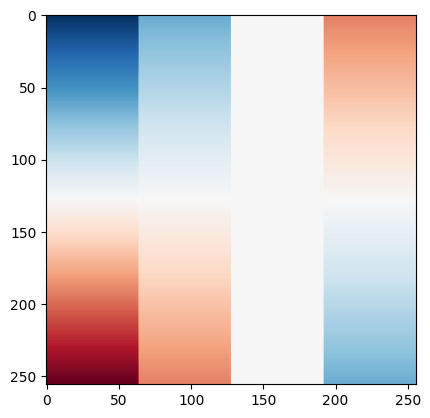

In [49]:
plt.imshow(res, cmap='RdBu')